In [ ]:
import pandas as pd
import numpy as np
from copy import copy
import torch
import matplotlib.pyplot as plt

from google.colab import drive
from IPython.display import clear_output

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/CourseWork Resource/ML/'

In [ ]:
def file_to_data(filename):
    
    # read file
    raw = pd.read_csv(filename)
    
    # define columns to be extracted
    ndvi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., ndvi_mean24
    savi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., savi_mean24
    evi_col = ['ndvi_mean'+str(i) for i in range(1, 24+1)] # ndvi_mean1, ..., evi_mean24

    # extract each feature
    ndvi_timeseries = raw[ndvi_col]
    savi_timeseries = raw[savi_col]
    evi_timeseries = raw[evi_col]
    
    # dimension stack
    data = np.dstack([ndvi_timeseries, savi_timeseries, evi_timeseries])
    
    # get only label
    label = raw.iloc[:, -1]
    
    return data, label

def data_to_lv1_x_y(data, labels):
    
    # export all X
    # but reclass the plant cane -> 100, ratoon cane -> 200
    target = copy(labels)
    target[target > 200] = 200
    target[(target < 200) & (target > 100)] = 100
    
    return data, target

def data_to_lv2_x_y(data, target):
    
    # export X plant which labels are 100-200
    X_plant = data[(target > 100) & (target <200)]
    
    # export X ratoon which labels are >200
    X_ratoon = data[target > 200]
    
    # export y plant which labels are 100-200
    y_plant = target[(target > 100) & (target < 200)]
    
    # export y ratoon which labels are >200
    y_ratoon = target[target > 200]
    
    return X_plant, y_plant, X_ratoon, y_ratoon

def label_encode(y):
    
    target = copy(y)
    # redefine the cane plantation label to be 1 - 24
    new_y = [int(str(label)[1:]) for label in target]
    
    return np.array(new_y)

In [ ]:
data_train, labels_train = file_to_data('/content/drive/MyDrive/CourseWork Resource/ML/training_data_1718.csv')
data_test, labels_test = file_to_data('/content/drive/MyDrive/CourseWork Resource/ML/training_data_1819.csv')

In [ ]:
X_plant_train, y_plant_train, X_ratoon_train, y_ratoon_train = data_to_lv2_x_y(data_train, labels_train)
X_plant_test, y_plant_test, X_ratoon_test, y_ratoon_test = data_to_lv2_x_y(data_test, labels_test)

In [ ]:
y_plant_train = label_encode(y_plant_train)-1
y_ratoon_train = label_encode(y_ratoon_train)-1

y_plant_test = label_encode(y_plant_test)-1
y_ratoon_test = label_encode(y_ratoon_test)-1

In [ ]:
print(f'numeric class of y train: {np.unique(y_plant_train)}')
print(f'numeric class of y test: {np.unique(y_plant_test)}')

numeric class of y train: [ 0  1  2  3  4  5  6  7 20 21 22 23]
numeric class of y test: [ 0  1  2  3  4  5  6  7 20 22 23]


In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [ ]:
shape_plant = X_plant_train.shape
shape_ratoon = X_ratoon_train.shape
print(Counter(y_plant_train))
print(Counter(y_ratoon_train))

Counter({3: 980, 4: 938, 5: 725, 2: 721, 1: 435, 0: 256, 6: 192, 23: 85, 7: 57, 22: 43, 21: 41, 20: 16})
Counter({4: 1905, 5: 1625, 3: 1307, 2: 1221, 1: 773, 6: 697, 7: 168, 0: 166, 23: 16})


In [ ]:
X_plant_train = X_plant_train.reshape(X_plant_train.shape[0], -1)
X_ratoon_train = X_ratoon_train.reshape(X_ratoon_train.shape[0], -1)
print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (4489, 72)
X ratoon train: (7878, 72)


In [ ]:
# instantiating the random over sampler 
ros = RandomOverSampler()
# resampling X, y
X_plant_train, y_plant_train = ros.fit_resample(X_plant_train, y_plant_train)
X_ratoon_train, y_ratoon_train = ros.fit_resample(X_ratoon_train, y_ratoon_train)

print(f'after oversampled-> X plant shape: {X_plant_train.shape}')
print(f'after oversampled-> X ratoon shape: {X_ratoon_train.shape}')

after oversampled-> X plant shape: (11760, 72)
after oversampled-> X ratoon shape: (17145, 72)


In [ ]:
X_plant_train = X_plant_train.reshape(X_plant_train.shape[0], 24,3)
X_ratoon_train = X_ratoon_train.reshape(X_ratoon_train.shape[0], 24,3)

print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (11760, 24, 3)
X ratoon train: (17145, 24, 3)


In [ ]:
print(Counter(y_plant_train))
print(Counter(y_ratoon_train))

Counter({0: 980, 1: 980, 2: 980, 3: 980, 4: 980, 5: 980, 6: 980, 7: 980, 20: 980, 21: 980, 22: 980, 23: 980})
Counter({0: 1905, 1: 1905, 2: 1905, 3: 1905, 4: 1905, 5: 1905, 6: 1905, 7: 1905, 23: 1905})


In [ ]:
X_plant_train = X_plant_train.transpose(0,2,1)[:, np.newaxis,:,:]
X_ratoon_train = X_ratoon_train.transpose(0,2,1)[:, np.newaxis,:,:]

In [ ]:
print(f'X plant train: {X_plant_train.shape}')
print(f'X ratoon train: {X_ratoon_train.shape}')

X plant train: (11760, 1, 3, 24)
X ratoon train: (17145, 1, 3, 24)


In [ ]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

def Xy_dataloader(X_numpy, y_numpy, batch_size=32):
    
    X_tensor = torch.tensor(X_numpy).float()
    y_tensor = torch.tensor(y_numpy).long()
    
    dataset = TensorDataset(X_tensor, y_tensor)

    loader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
    
    return loader

In [ ]:
from sklearn.model_selection import train_test_split

X_plant_train, X_plant_valid, y_plant_train, y_plant_valid = train_test_split(X_plant_train, y_plant_train  , test_size=0.3, stratify=y_plant_train)


In [ ]:
X_ratoon_train, X_ratoon_valid, y_ratoon_train, y_ratoon_valid = train_test_split(X_ratoon_train, y_ratoon_train, test_size=0.3, stratify=y_ratoon_train)

In [ ]:
plant_train_loader = Xy_dataloader(X_plant_train, y_plant_train, 64)
plant_valid_loader = Xy_dataloader(X_plant_valid, y_plant_valid, 64)

ratoon_train_loader = Xy_dataloader(X_ratoon_train, y_ratoon_train, 64)
ratoon_valid_loader = Xy_dataloader(X_ratoon_valid, y_ratoon_valid, 64)

In [ ]:
import torch
from torch import nn

In [ ]:

class RNN_lv1(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        
        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
     
        
        #[batch size, seq len, embed dim]
        out, (hn, cn) = self.rnn(x)
        x = self.dropout(hn.squeeze(0))
        x = self.fc(x)
        
        return x

In [ ]:

class CNN_lv2(nn.Module):
    
    def __init__(self, output_dim):
        super().__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, (1,3), stride=1, padding='valid'),
                                  nn.BatchNorm2d(16),
                                  nn.ReLU())
        
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, (1,3), stride=1, padding='valid'),
                                  nn.BatchNorm2d(32),
                                  nn.ReLU(),
                                  nn.MaxPool2d(2,2))
        
        
        self.dropout = nn.Dropout(0.5)


        self.fc1 = nn.Linear(32*1*10, 1024)
        self.fc2 = nn.Linear(1024, output_dim)
        
    def forward(self, x):
     
        
        #[batch size, seq len, embed dim]
        x = self.conv1(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = self.dropout(x)
        # print(x.shape)
        x = x.reshape(x.size(0),-1)
        x = self.fc1(x)
        x = self.fc2(x)

        
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [ ]:
model_plant = RNN_lv1(3, 512, 24).to(device)
model_ratoon = RNN_lv1(3, 512, 24).to(device)

In [ ]:
model_plant = CNN_lv2(24).to(device)
model_ratoon = CNN_lv2(24).to(device)

In [ ]:
import torch.optim as optim

optimizer_plant = optim.Adam(model_plant.parameters(), lr=0.001) #<----changed to Adam
criterion_plant = nn.CrossEntropyLoss() #combine sigmoid with binary cross entropy

optimizer_ratoon = optim.Adam(model_ratoon.parameters(), lr=0.001) #<----changed to Adam
criterion_ratoon = nn.CrossEntropyLoss() #combine sigmoid with binary cross entropy

In [ ]:
def train_model(model, train_dataloader, valid_dataloader, 
                epochs, criterion, optimizer, print_epoch=1000):
    
    loss_train = []
    loss_valid = []
    acc_train = []
    acc_valid = []
    
    for i in range(1, epochs+1):
        
        # ===================TRAIN ======================
        model.train()
        
        epoch_loss = 0
        correct = 0
        
        for x, y in train_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
            
            #backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        acc_train.append(100 * correct / len(train_dataloader.dataset))
        loss_train.append(epoch_loss/len(train_dataloader))
        # loss_train.append(epoch_loss)
        
        # ===================VALIDATION =================
        model.eval()
    
        epoch_loss = 0
        correct = 0
        
        for x, y in valid_dataloader:
            
            x = x.to(device)
            y = y.to(device)
            
            out = model(x)
            
            loss = criterion(out, y)
            
            _,pred = torch.max(out, 1)
            
            correct += (pred == y).to('cpu').float().sum()
            
            epoch_loss += loss.item()
        
        acc_valid.append(100 * correct / len(valid_dataloader.dataset))
        loss_valid.append(epoch_loss/len(valid_dataloader))
        # loss_valid.append(epoch_loss)
        
        # ================= PRINT ===========================
        if i % print_epoch == 0 :
            clear_output(wait=True)
            print(f'epoch {i}/{epochs} train loss: {np.round(loss_train[-1],5)} train acc: {np.round(acc_train[-1],5)} validation loss: {np.round(loss_valid[-1],5)} validation acc: {np.round(acc_valid[-1],5)}')
            plt.plot(loss_train, label='train')
            plt.plot(loss_valid, label='test')
            plt.title('Loss during Training')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()

            plt.plot(acc_train, label='train')
            plt.plot(acc_valid, label='test')
            plt.title('Accuracy during Training')
            plt.xlabel('epoch')
            plt.ylabel('accuracy')
            plt.legend()
            plt.show()    
            
    return model, loss_train, loss_valid, acc_train, acc_valid
            

epoch 200/200 train loss: 1.13984 train acc: 54.68901824951172 validation loss: 1.18687 validation acc: 52.806121826171875


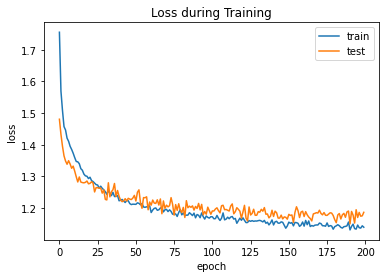

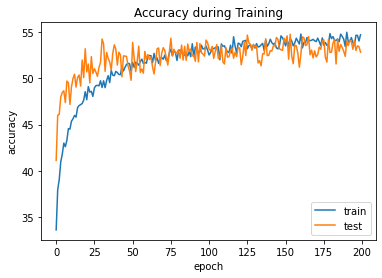

In [ ]:
model_plant, loss_train_plant, loss_valid_plant, acc_train_plant, acc_valid_plant = train_model(model_plant, plant_train_loader, plant_valid_loader, 200, criterion_plant, optimizer_plant, 1)

epoch 200/200 train loss: 1.17309 train acc: 50.0041618347168 validation loss: 1.16544 validation acc: 50.369361877441406


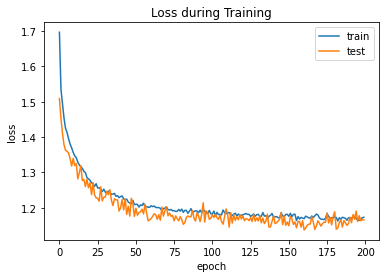

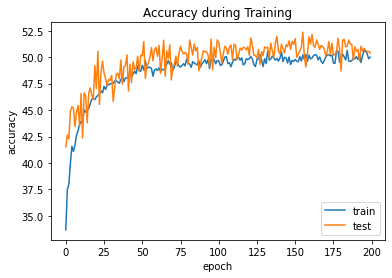

In [ ]:
model_ratoon, loss_train_ratoon, loss_valid_ratoon, acc_train_ratoon, acc_valid_ratoon = train_model(model_ratoon, ratoon_train_loader, ratoon_valid_loader, 200, criterion_ratoon, optimizer_ratoon, 1)

In [ ]:
def predict_model(model, X_test):
    
    model.eval()
    
    x = torch.tensor(X_test).float()
    
    x = x.to(device)
            
    out = model(x).to('cpu')
    
    pred = torch.max(out, 1)[1].numpy()
    
    return pred

In [ ]:
y_pred_plant = predict_model(model_plant, X_plant_valid)
y_pred_ratoon = predict_model(model_ratoon, X_ratoon_valid)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_ratoon_valid, y_pred_ratoon))
print(classification_report(y_plant_valid, y_pred_plant))

              precision    recall  f1-score   support

           0       0.52      0.75      0.61       571
           1       0.37      0.58      0.45       571
           2       0.42      0.35      0.38       572
           3       0.55      0.05      0.09       572
           4       0.34      0.32      0.33       571
           5       0.36      0.26      0.30       572
           6       0.67      0.24      0.35       571
           7       0.62      1.00      0.76       572
          23       0.70      1.00      0.82       572

    accuracy                           0.50      5144
   macro avg       0.50      0.50      0.45      5144
weighted avg       0.50      0.50      0.45      5144

              precision    recall  f1-score   support

           0       0.39      0.50      0.44       294
           1       0.33      0.49      0.39       294
           2       0.25      0.11      0.15       294
           3       0.21      0.17      0.19       294
           4       0.45 

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix_plant = confusion_matrix(y_plant_valid, y_pred_plant)
cf_matrix_ratoon = confusion_matrix(y_ratoon_valid, y_pred_ratoon)

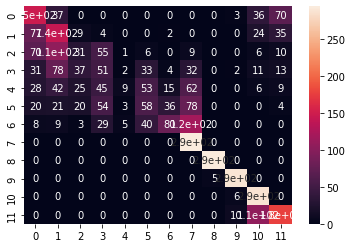

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix_plant, annot=True)


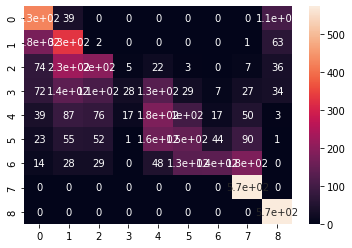

In [ ]:
sns.heatmap(cf_matrix_ratoon, annot=True)

In [ ]:
drive.flush_and_unmount()